In [1]:
import jax

jax.config.update("jax_enable_x64", True)
from torch.utils.data import DataLoader
import optax
import jax.numpy as jnp

from core import (
    SpecQDataset,
    create_train_step,
    loss as loss_fn,
    gate_loss,
    X,
    Y,
    Z,
    calculate_expvals,
    plot_expvals,
    gate_fidelity,
    Wo_2_level
)
from model import BasicBlackBox
from exp_data_0019 import get_exp_data
import specq_dev.specq.shared as specq

from jaxopt import ProjectedGradient
from jaxopt.projection import projection_box
import pandas as pd
import matplotlib.pyplot as plt
from alive_progress import alive_bar
from torch.utils.data import DataLoader, random_split

In [2]:
pulse_parameters, unitaries, expectations, pulse_sequence, simulator = get_exp_data()

Loaded data from 0019
Prepared the waveforms for the experiment 0019
Got the unitaries for the experiment 0019
Finished preparing the data for the experiment 0019


In [3]:
# Final goal of setting up is to create a dataset and a dataloader
dataset = SpecQDataset(
    pulse_parameters=pulse_parameters,
    unitaries=unitaries,
    expectation_values=expectations,
)

batch_size = 150
# Randomly split dataset into training and validation
train_dataset, val_dataset = random_split(dataset, [int(0.8 * len(dataset)), int(0.2 * len(dataset))])

# dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [4]:
key, model_key = jax.random.split(jax.random.PRNGKey(0))
model = BasicBlackBox(feature_size=30)
# optimiser = optax.adam(learning_rate=1e-3)

warmup_start_lr, warmup_steps = 1e-6, 1000
start_lr, end_lr, steps = 1e-2, 1e-5, 10_000
lr_scheduler = optax.join_schedules(
    [
        optax.linear_schedule(
            warmup_start_lr,
            start_lr,
            warmup_steps,
        ),
        optax.linear_schedule(
            start_lr,
            end_lr,
            steps - warmup_steps,
        ),
    ],
    [warmup_steps],
)

optimiser = optax.adam(lr_scheduler)

train_step, test_step, model_params, opt_state = create_train_step(
    key=model_key,
    model=model,
    optimiser=optimiser,
    loss_fn=lambda params, pulse_parameters, unitaries, expectations: loss_fn(
        params, pulse_parameters, unitaries, expectations, model
    ),
    input_shape=(batch_size, 160),
)

In [5]:
def with_validation_train(
    train_dataloader: DataLoader,
    val_dataloader: DataLoader,
    train_step,
    test_step,
    model_params,
    opt_state,
):

    history = []
    total_len = len(train_dataloader)

    NUM_EPOCHS = 1250

    with alive_bar(int(NUM_EPOCHS * total_len), force_tty=True) as bar:
        for epoch in range(NUM_EPOCHS):
            total_loss = 0.0
            for i, batch in enumerate(train_dataloader):

                _pulse_parameters = batch["x0"].numpy()
                _unitaries = batch["x1"].numpy()
                _expectations = batch["y"].numpy()

                model_params, opt_state, loss = train_step(
                    model_params, opt_state, _pulse_parameters, _unitaries, _expectations
                )

                history.append(
                    {
                        "epoch": epoch,
                        "step": i,
                        "loss": float(loss),
                        "global_step": epoch * total_len + i,
                        "val_loss": None,
                    }
                )

                total_loss += loss

                bar()

            # Validation
            val_loss = 0.0
            for i, batch in enumerate(val_dataloader):

                _pulse_parameters = batch["x0"].numpy()
                _unitaries = batch["x1"].numpy()
                _expectations = batch["y"].numpy()

                val_loss += test_step(model_params, _pulse_parameters, _unitaries, _expectations)

            history[-1]["val_loss"] = float(val_loss / len(val_dataloader))


    return model_params, opt_state, history

model_params, opt_state, history = with_validation_train(
    train_dataloader,
    val_dataloader,
    train_step,
    test_step,
    model_params,
    opt_state,
)

on 0: /Users/porametpathumsoot/miniconda3/envs/specq-dev/lib/python3.12/site-packages/jax/_src/lax/lax.py:2660: ComplexWarning: Casting complex values to real discards the imaginary part
        x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)


|████████████████████████████████████████| 10000/10000 [100%] in 44.8s (223.07/s


(<Figure size 1000x600 with 2 Axes>, array([<Axes: >, <Axes: >], dtype=object))

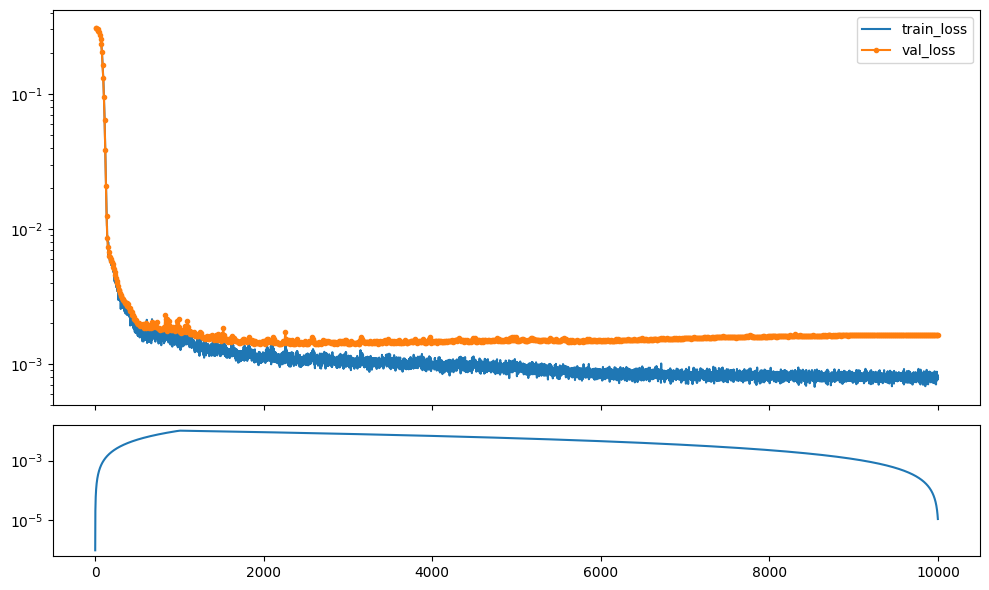

In [6]:
def plot_history(history, lr_scheduler):

    hist_df = pd.DataFrame(history)
    train = hist_df[["global_step", "loss"]].values

    train_x = train[:, 0]
    train_y = train[:, 1]

    validate = hist_df[["global_step", "val_loss"]].replace(0, jnp.nan).dropna().values

    validate_x = validate[:, 0]
    validate_y = validate[:, 1]
    # The second plot has height ratio 2
    fig, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True, height_ratios=[3,1])

    # The first plot is the training loss and the validation loss
    ax[0].plot(train_x, train_y, label="train_loss")
    ax[0].plot(validate_x, validate_y, '.-', label="val_loss")
    ax[0].set_yscale("log")

    # The second plot is the learning rate
    lr = lr_scheduler(train_x)
    ax[1].plot(train_x, lr, label="learning_rate")
    ax[1].set_yscale("log")
    ax[0].legend()

    fig.tight_layout()

    return fig, ax

plot_history(history, lr_scheduler)

In [7]:
target_unitary = X # jax.scipy.linalg.sqrtm(X)
fun = lambda x: gate_loss(x, model, model_params, simulator, pulse_sequence, target_unitary)

lower = jnp.array([-0.1] * 160)
upper = jnp.array([0.1] * 160)

key = jax.random.PRNGKey(23)
pulse_params = pulse_sequence.sample_params(key)
x0 = pulse_sequence.list_of_params_to_array(pulse_params)

pg = ProjectedGradient(fun=fun, projection=projection_box)
opt_params_2, state = pg.run(
    jnp.array(x0),
    hyperparams_proj=(lower, upper)
)

/Users/porametpathumsoot/miniconda3/envs/specq-dev/lib/python3.12/site-packages/jax/_src/lax/lax.py:2660: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)


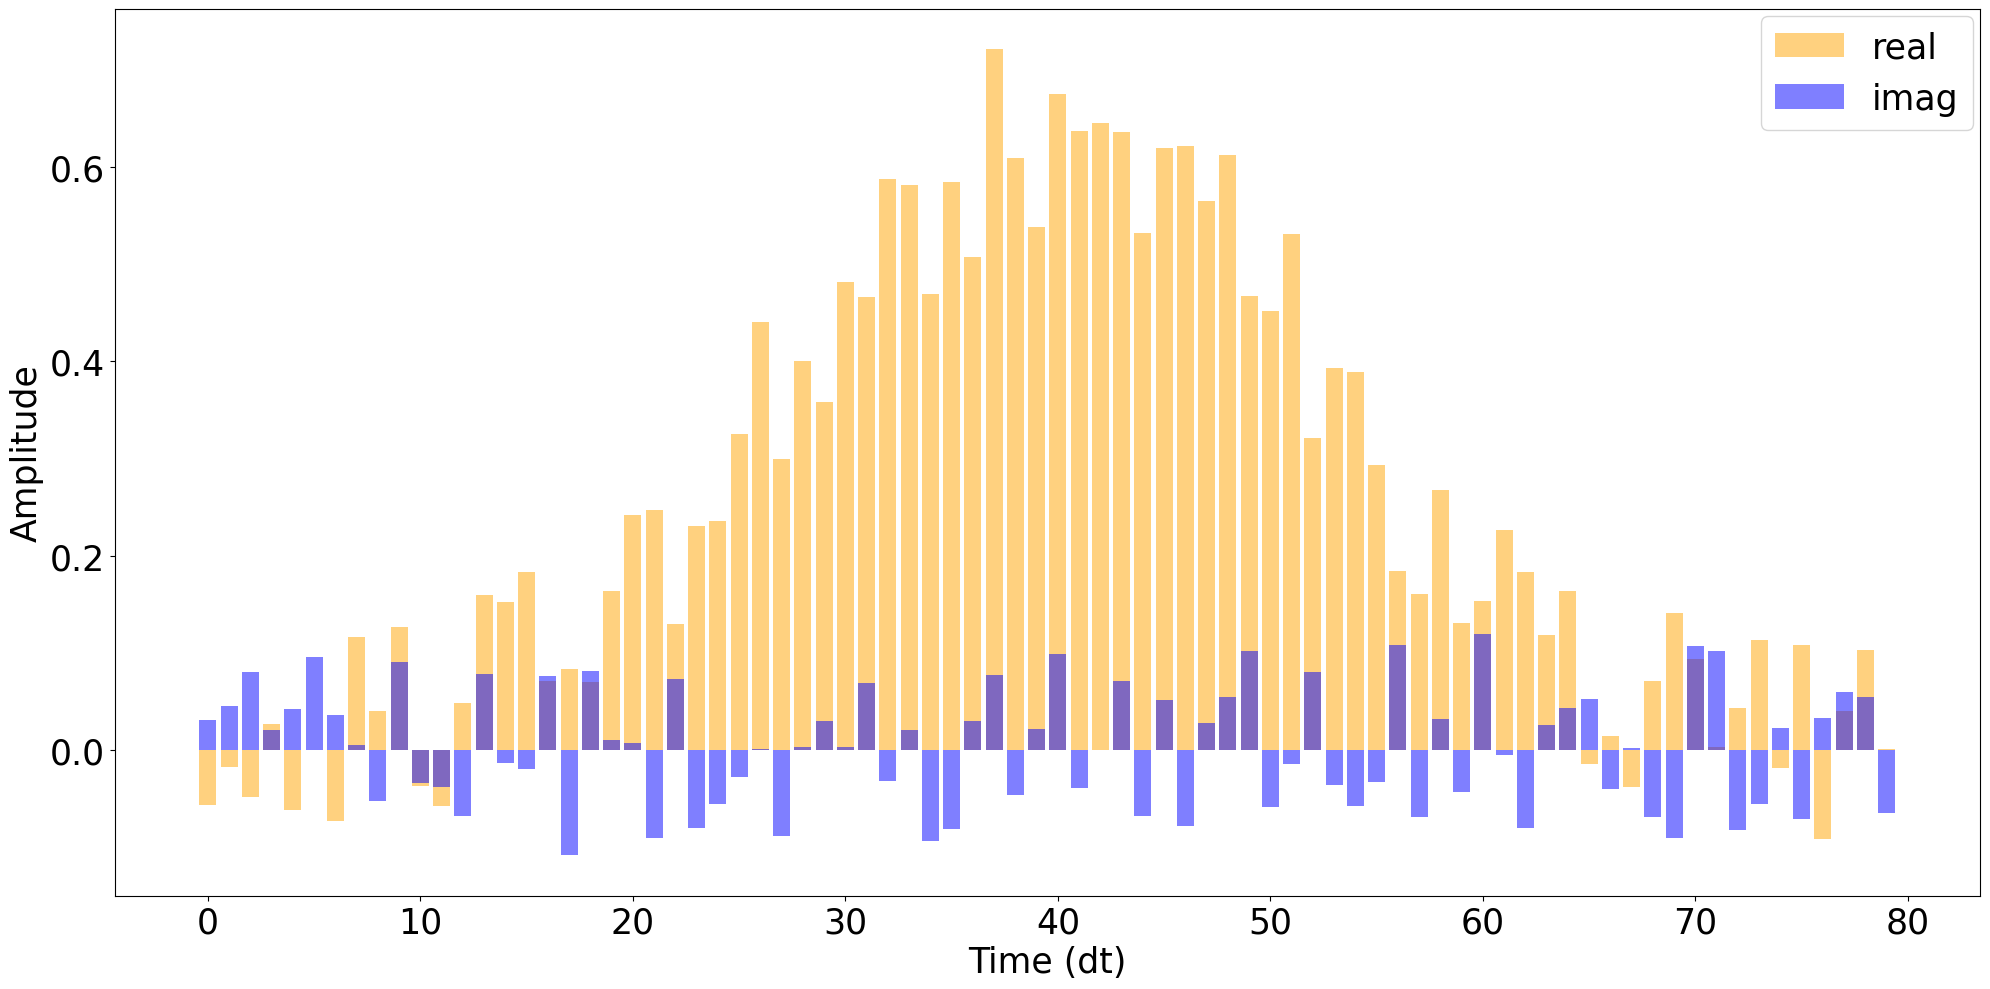

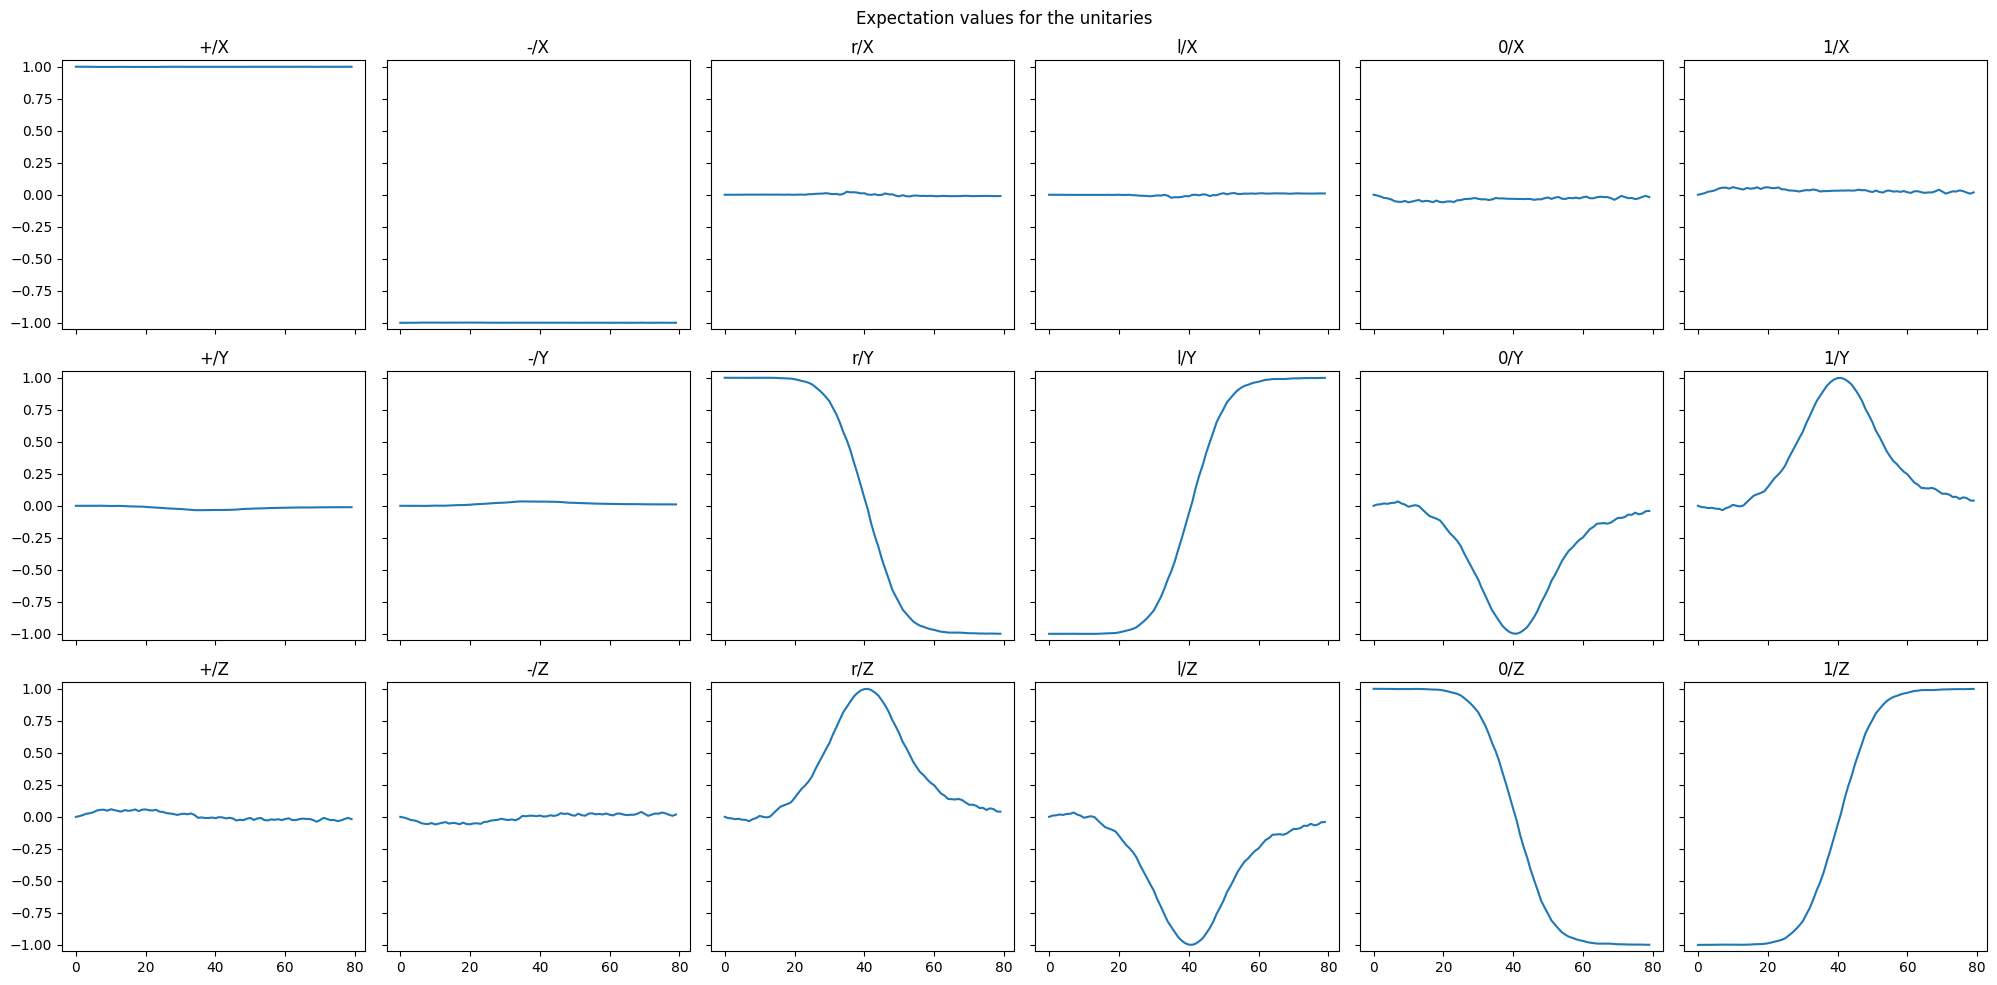

In [8]:
# Plot the optmized result
opt_pulse_params = pulse_sequence.array_to_list_of_params(opt_params_2)
pulse_sequence.draw(opt_pulse_params)

# Calculate the expectation values
waveforms = pulse_sequence.get_waveform(opt_pulse_params)
unitaries = simulator(waveforms)

expvals = calculate_expvals(unitaries)
plot_expvals(expvals)

In [9]:
Wo_params = model.apply(model_params, jnp.expand_dims(opt_params_2, axis=0))
Wo_params = jax.tree_map(lambda x: jnp.squeeze(x, 0), Wo_params)

fidelities = {}
for pauli_str, pauli_op in zip(["X", "Y", "Z"], [X, Y, Z]):
    Wo = Wo_2_level(U=Wo_params[pauli_str]["U"], D=Wo_params[pauli_str]["D"])
    # evaluate the fidleity to the Pauli operator
    fidelities[pauli_str] = gate_fidelity(Wo, pauli_op)

fidelities, gate_fidelity(unitaries[-1], target_unitary)

({'X': Array(0.99734933, dtype=float64),
  'Y': Array(0.99619952, dtype=float64),
  'Z': Array(0.99752887, dtype=float64)},
 Array(0.99947607, dtype=float64))